In [ ]:
#https://github.com/nlptown/nlp-notebooks/blob/master/Intent%20Classification%20with%20Small%20Transformers.ipynb
#https://raw.githubusercontent.com/huggingface/datasets/1.4.1/datasets/banking77/banking77.py

In [3]:
from datasets import load_dataset

dataset = load_dataset('banking77')
dataset

/Users/zaarr/.cache/huggingface/modules/datasets_modules/datasets/banking77/9898c11f6afa9521953d2ef205667b527bad14ef9cab445d470f16240c8c8ec4/banking77.py:59: FutureWarning: Dataset 'banking77' is deprecated and will be deleted. Use 'PolyAI/banking77' instead.
  warnings.warn(


Generating train split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3080 [00:00<?, ? examples/s]

Dataset banking77 downloaded and prepared to /Users/zaarr/.cache/huggingface/datasets/banking77/default/1.1.0/9898c11f6afa9521953d2ef205667b527bad14ef9cab445d470f16240c8c8ec4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10003
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 3080
    })
})

In [4]:
dataset["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['activate_my_card', 'age_limit', 'apple_pay_or_google_pay', 'atm_support', 'automatic_top_up', 'balance_not_updated_after_bank_transfer', 'balance_not_updated_after_cheque_or_cash_deposit', 'beneficiary_not_allowed', 'cancel_transfer', 'card_about_to_expire', 'card_acceptance', 'card_arrival', 'card_delivery_estimate', 'card_linking', 'card_not_working', 'card_payment_fee_charged', 'card_payment_not_recognised', 'card_payment_wrong_exchange_rate', 'card_swallowed', 'cash_withdrawal_charge', 'cash_withdrawal_not_recognised', 'change_pin', 'compromised_card', 'contactless_not_working', 'country_support', 'declined_card_payment', 'declined_cash_withdrawal', 'declined_transfer', 'direct_debit_payment_not_recognised', 'disposable_card_limits', 'edit_personal_details', 'exchange_charge', 'exchange_rate', 'exchange_via_app', 'extra_charge_on_statement', 'failed_transfer', 'fiat_currency_support', 'get_disposable_virtual_card

In [5]:
for item in dataset["train"]["text"][:5]:
    print(item)

I am still waiting on my card?
What can I do if my card still hasn't arrived after 2 weeks?
I have been waiting over a week. Is the card still coming?
Can I track my card while it is in the process of delivery?
How do I know if I will get my card, or if it is lost?


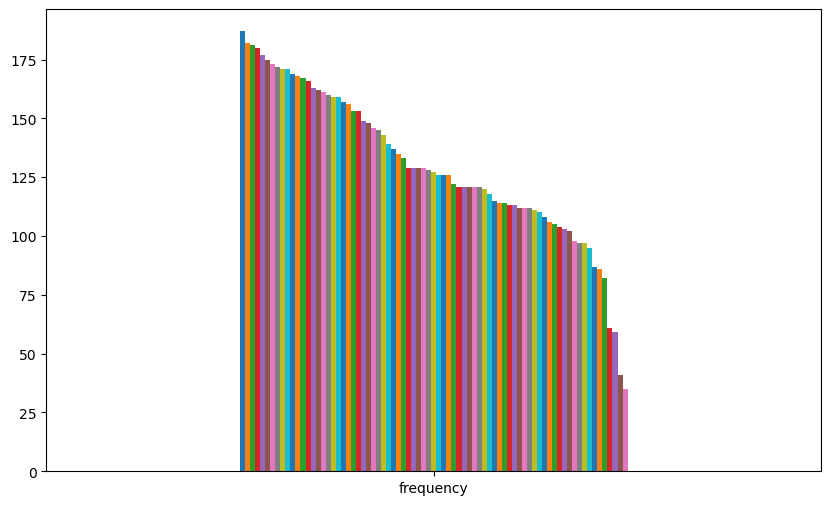

In [6]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

train_texts = [item["text"] for item in dataset["train"]]
train_labels = [item["label"] for item in dataset["train"]]

test_texts = [item["text"] for item in dataset["test"]]
test_labels = [item["label"] for item in dataset["test"]]

label_counter = Counter(train_labels)
label_names = dataset["train"].features["label"].names
label_frequencies = {label_names[label]: [label_counter[label]] for label in label_counter}

df = pd.DataFrame.from_dict(label_frequencies, orient="index", columns=["frequency"])
df = df.sort_values("frequency", ascending=False)

plt.rcParams['figure.figsize'] = (10,6)
ax = df.transpose().plot(kind="bar", rot=0)
ax.get_legend().remove()

In [7]:
from sklearn.model_selection import train_test_split

train_texts, dev_texts, train_labels, dev_labels = train_test_split(train_texts, 
                                                                    train_labels, 
                                                                    test_size=0.1, 
                                                                    shuffle=True, 
                                                                    random_state=1)

print("Train:", len(train_texts))
print("Dev:", len(dev_texts))
print("Test:", len(test_texts))

Train: 9002
Dev: 1001
Test: 3080


In [10]:
import torch

class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['label'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

In [11]:
from sklearn.metrics import accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc
    }


In [12]:
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification

model_ids = ["prajjwal1/bert-tiny", "prajjwal1/bert-mini", 
             "prajjwal1/bert-small", "prajjwal1/bert-medium",
             "albert-base-v2", "albert-large-v2", "bert-base-uncased"]

accuracies = []
for model_id in model_ids:
    
    print(f"*** {model_id} ***")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=len(label_names))

    train_texts_encoded = tokenizer(train_texts, padding=True, truncation=True, return_tensors="pt")
    dev_texts_encoded = tokenizer(dev_texts, padding=True, truncation=True, return_tensors="pt")
    test_texts_encoded = tokenizer(test_texts, padding=True, truncation=True, return_tensors="pt")
    
    train_dataset = ClassificationDataset(train_texts_encoded, train_labels)
    dev_dataset = ClassificationDataset(dev_texts_encoded, dev_labels)
    test_dataset = ClassificationDataset(test_texts_encoded, test_labels)
    
    training_args = TrainingArguments(
        output_dir='./results',
        num_train_epochs=3,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=64,
        warmup_steps=int(len(train_dataset)/16),
        weight_decay=0.01,
        logging_dir='./logs',
        evaluation_strategy="steps",
        eval_steps=50,
        save_steps=50,
        save_total_limit=10,
        load_best_model_at_end=True,
        no_cuda=False
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        compute_metrics=compute_metrics,
        train_dataset=train_dataset,
        eval_dataset=dev_dataset,
    )

    trainer.train()
    test_results = trainer.evaluate(test_dataset)
    
    accuracies.append(test_results["eval_accuracy"])

*** prajjwal1/bert-tiny ***


Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/17.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

Step,Training Loss,Validation Loss,Accuracy
50,No log,4.354899,0.015984
100,No log,4.352106,0.015984
150,No log,4.347859,0.015984
200,No log,4.342193,0.013986
250,No log,4.333172,0.012987
300,No log,4.322857,0.014985
350,No log,4.309462,0.013986
400,No log,4.294309,0.023976
450,No log,4.257319,0.052947
500,4.329800,4.211791,0.089910


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use so

Model weights saved in ./results/checkpoint-700/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-200] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-750
Configuration saved in ./results/checkpoint-750/config.json
Model weights saved in ./results/checkpoint-750/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-250] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().d

Model weights saved in ./results/checkpoint-1300/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-800] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1350
Configuration saved in ./results/checkpoint-1350/config.json
Model weights saved in ./results/checkpoint-1350/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-850] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone

*** prajjwal1/bert-mini ***


Could not locate the tokenizer configuration file, will try to use the model config instead.


Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

loading configuration file config.json from cache at /Users/zaarr/.cache/huggingface/hub/models--prajjwal1--bert-mini/snapshots/5e123abc2480f0c4b4cac186d3b3f09299c258fc/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-mini",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

loading file vocab.txt from cache at /Users/zaarr/.cache/huggingface/hub/models--prajjwal1--bert-mini/snapshots/5e123abc2480f0c4b4cac186d3b3f09299c258fc/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /Users/zaarr/.cache/huggingface/hub/models--prajjwal1--bert-mini/snapshots/5e123abc2480f0c4b4cac186d3b3f09299c258fc/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-mini",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedd

Downloading:   0%|          | 0.00/45.1M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /Users/zaarr/.cache/huggingface/hub/models--prajjwal1--bert-mini/snapshots/5e123abc2480f0c4b4cac186d3b3f09299c258fc/pytorch_model.bin
Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you ex

Step,Training Loss,Validation Loss,Accuracy
50,No log,4.356071,0.019980
100,No log,4.346424,0.015984
150,No log,4.328240,0.021978
200,No log,4.308884,0.026973
250,No log,4.278137,0.034965
300,No log,4.239903,0.045954
350,No log,4.176839,0.084915
400,No log,4.120913,0.114885
450,No log,3.984796,0.170829
500,4.244300,3.855187,0.268731


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1200] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1250] due to args.save_to

  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-650
Configuration saved in ./results/checkpoint-650/config.json
Model weights saved in ./results/checkpoint-650/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-150] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-700
Configuration saved in ./results/checkpoint-700/config.json
Model weights saved in ./results/checkpoint-700/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-200] due to args.save_total_limit
/var/folders/6_/d50l

  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1250
Configuration saved in ./results/checkpoint-1250/config.json
Model weights saved in ./results/checkpoint-1250/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-750] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1300
Configuration saved in ./results/checkpoint-1300/config.json
Model weights saved in ./results/checkpoint-1300/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-800] due to args.save_total_limit
/var/folders/6

*** prajjwal1/bert-small ***


Could not locate the tokenizer configuration file, will try to use the model config instead.


Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

loading configuration file config.json from cache at /Users/zaarr/.cache/huggingface/hub/models--prajjwal1--bert-small/snapshots/0ec5f86f27c1a77d704439db5e01c307ea11b9d4/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-small",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

loading file vocab.txt from cache at /Users/zaarr/.cache/huggingface/hub/models--prajjwal1--bert-small/snapshots/0ec5f86f27c1a77d704439db5e01c307ea11b9d4/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /Users/zaarr/.cache/huggingface/hub/models--prajjwal1--bert-small/snapshots/0ec5f86f27c1a77d704439db5e01c307ea11b9d4/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-small",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_emb

Downloading:   0%|          | 0.00/116M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /Users/zaarr/.cache/huggingface/hub/models--prajjwal1--bert-small/snapshots/0ec5f86f27c1a77d704439db5e01c307ea11b9d4/pytorch_model.bin
Some weights of the model checkpoint at prajjwal1/bert-small were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you 

Step,Training Loss,Validation Loss,Accuracy
50,No log,4.363510,0.009990
100,No log,4.319171,0.015984
150,No log,4.266430,0.014985
200,No log,4.180545,0.062937
250,No log,4.032411,0.166833
300,No log,3.803262,0.271728
350,No log,3.504495,0.400599
400,No log,3.230228,0.432567
450,No log,2.897503,0.526474
500,3.877900,2.638017,0.550450


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1200] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1250] due to args.save_to

  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-650
Configuration saved in ./results/checkpoint-650/config.json
Model weights saved in ./results/checkpoint-650/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-150] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-700
Configuration saved in ./results/checkpoint-700/config.json
Model weights saved in ./results/checkpoint-700/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-200] due to args.save_total_limit
/var/folders/6_/d50l

  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1250
Configuration saved in ./results/checkpoint-1250/config.json
Model weights saved in ./results/checkpoint-1250/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-750] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1300
Configuration saved in ./results/checkpoint-1300/config.json
Model weights saved in ./results/checkpoint-1300/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-800] due to args.save_total_limit
/var/folders/6

*** prajjwal1/bert-medium ***


Could not locate the tokenizer configuration file, will try to use the model config instead.


Downloading:   0%|          | 0.00/286 [00:00<?, ?B/s]

loading configuration file config.json from cache at /Users/zaarr/.cache/huggingface/hub/models--prajjwal1--bert-medium/snapshots/ce27ec2944bd32b66ed837edb9c77eb7301b8ecc/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-medium",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 8,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

loading file vocab.txt from cache at /Users/zaarr/.cache/huggingface/hub/models--prajjwal1--bert-medium/snapshots/ce27ec2944bd32b66ed837edb9c77eb7301b8ecc/vocab.txt
loading file tokenizer.json from cache at None
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at None
loading configuration file config.json from cache at /Users/zaarr/.cache/huggingface/hub/models--prajjwal1--bert-medium/snapshots/ce27ec2944bd32b66ed837edb9c77eb7301b8ecc/config.json
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-medium",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 8,
  "pad_token_id": 0,
  "position_

Downloading:   0%|          | 0.00/167M [00:00<?, ?B/s]

loading weights file pytorch_model.bin from cache at /Users/zaarr/.cache/huggingface/hub/models--prajjwal1--bert-medium/snapshots/ce27ec2944bd32b66ed837edb9c77eb7301b8ecc/pytorch_model.bin
Some weights of the model checkpoint at prajjwal1/bert-medium were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that yo

Step,Training Loss,Validation Loss,Accuracy
50,No log,4.334461,0.010989
100,No log,4.291095,0.033966
150,No log,4.220604,0.070929
200,No log,4.084690,0.157842
250,No log,3.852195,0.258741
300,No log,3.570946,0.413586
350,No log,3.249877,0.490509
400,No log,2.953640,0.529471
450,No log,2.647262,0.587413
500,3.742700,2.372876,0.631369


***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-50
Configuration saved in ./results/checkpoint-50/config.json
Model weights saved in ./results/checkpoint-50/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1200] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-100
Configuration saved in ./results/checkpoint-100/config.json
Model weights saved in ./results/checkpoint-100/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-1250] due to args.save_to

  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-650
Configuration saved in ./results/checkpoint-650/config.json
Model weights saved in ./results/checkpoint-650/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-150] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-700
Configuration saved in ./results/checkpoint-700/config.json
Model weights saved in ./results/checkpoint-700/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-200] due to args.save_total_limit
/var/folders/6_/d50l

  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1250
Configuration saved in ./results/checkpoint-1250/config.json
Model weights saved in ./results/checkpoint-1250/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-750] due to args.save_total_limit
/var/folders/6_/d50lgm19265fhn6q8znq45040000gn/T/ipykernel_4750/48522100.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1001
  Batch size = 64
Saving model checkpoint to ./results/checkpoint-1300
Configuration saved in ./results/checkpoint-1300/config.json
Model weights saved in ./results/checkpoint-1300/pytorch_model.bin
Deleting older checkpoint [results/checkpoint-800] due to args.save_total_limit
/var/folders/6

*** albert-base-v2 ***


FileNotFoundError: [Errno 2] No such file or directory: '/Users/zaarr/.cache/huggingface/hub/models--albert-base-v2/refs/main'

In [ ]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"model": accuracies}, index=model_ids)

print(df)
plt.rcParams['figure.figsize'] = (10,6)
ax = df.transpose().plot(kind="bar", rot=0)
ax.legend(loc=4)